### Customer Analytics for E-commerce Platform:

##### Data Cleaning & Preprocessing:
###### Handle missing values (impute or drop missing values).
###### Convert timestamps and data types as needed.
###### calculate the running total of orders
###### Calculate key metrics like total order value per customer, average order size
###### Filter data for customers who spent over a certain threshold >500 rs spent 
###### Perform transformations to identify the highest-value product category, or calculate the longest shipping delays by joining product and shipping data
###### You could plot the distribution of customer spending or visualize the shipping delays for top products[Matplotlib/Seaborn to visualize trends]
 
####Conclusion: 
###### Which product categories generate the most revenue
###### What are the key characteristics of high-value customers.
###### Average shipping times by product category.

#### Reading all the datasets from dbfs

In [0]:
products_data = spark.read.format("csv").option("header", True).option('inferSchema',True).load("dbfs:/FileStore/shared_uploads/subhanshaik677@gmail.com/products1_1.csv")
shipping_data = spark.read.format("csv").option("header", True).option('inferSchema',True).load("dbfs:/FileStore/shared_uploads/subhanshaik677@gmail.com/shipping.csv")
orders_data = spark.read.format("csv").option("header",True).option('inferSchema',True).load("dbfs:/FileStore/shared_uploads/subhanshaik677@gmail.com/orders.csv")
customers_data = spark.read.format("csv").option("header", True).option('inferSchema',True).load("dbfs:/FileStore/shared_uploads/subhanshaik677@gmail.com/customers__1_.csv")

In [0]:
### Displaying all the datasets schemas.
def display_data(*data):
    for i in data:
        i.printSchema()

display_data(products_data, shipping_data, orders_data, customers_data)

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- stock_quantity: integer (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- delivery_date: date (nullable = true)
 |-- status: string (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- total_price: double (nullable = true)

root
 |-- customer_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- address: string (nullable = true)
 |-- signup_date: date (nullable = true)



#### Removing null values from every dataset.

In [0]:
def dropping_null_values(*data):
    for i in data:
        i.dropna()
    return 'Successfully dropped the null values in all datasets'
dropping_null_values(products_data, shipping_data, orders_data, customers_data)

Out[95]: 'Successfully dropped the null values in all datasets'

#### converting all the datatypes based upon our requirment. mainly focused on date data type.

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
customers_data=customers_data.withColumn('signup_date',col('signup_date').cast(DateType()))
orders_data=orders_data.withColumn('order_date',col('order_date').cast(DateType()))
shipping_data=shipping_data.withColumn('delivery_date',col('delivery_date').cast(DateType()))

#### total value price of orders for each customer
##### displayed only first 10 rows

In [0]:
total_order_value_per_customer=orders_data.groupby('customer_id').agg(sum('total_price').alias('Total value'))\
        .join(customers_data.select('customer_id','name'),on='customer_id',how='inner')
total_order_value_per_customer=total_order_value_per_customer.select('customer_id','name','Total value')
total_order_value_per_customer.orderBy(col('customer_id')).limit(10).display()

customer_id,name,Total value
1,Gregory Miller,48687.24999999999
2,John Perry,13309.909999999998
3,Cory Perez,26942.010000000002
4,Alicia Howard,30384.48
5,Lisa Howard,7464.11
6,John Chavez,5664.650000000001
7,Nathan Stafford,43929.4
8,Christopher Fox,19934.87
9,Scott Larsen,17619.54
10,Taylor Gordon,43288.14


#### Average of quantity of orders per each customer
##### Displayed only first 10 rows

In [0]:
average_order_size_per_customer=orders_data.groupby('customer_id').agg(avg('quantity').alias('Average of Quantity'))\
    .join(customers_data.select('customer_id','name'),on='customer_id',how='inner')
average_order_size_per_customer=average_order_size_per_customer.select('customer_id','name','Average of Quantity')
average_order_size_per_customer.orderBy('customer_id').limit(10).display()

customer_id,name,Average of Quantity
1,Gregory Miller,3.0
2,John Perry,2.0
3,Cory Perez,2.0
4,Alicia Howard,2.8
5,Lisa Howard,1.0
6,John Chavez,1.5
7,Nathan Stafford,2.75
8,Christopher Fox,2.25
9,Scott Larsen,1.25
10,Taylor Gordon,3.5


#### Filtering data based upon threshold value 50000
###### As the price values are high in our dataset we use 50000 as a threhsold value.
###### Displayed only first 10 rows

In [0]:
Prime_customers=total_order_value_per_customer.filter(col('Total value')>50000)
Prime_customers.orderBy(col('Total value').desc()).limit(10).display()
print(f'We have {Prime_customers.count()} members as Prime_customers')

customer_id,name,Total value
386,Alan Hall,99906.87999999998
506,Erica Anthony,94867.84999999998
840,Beverly Martinez,94867.17000000001
425,Christina Rivera,94238.27999999998
921,Sue Acosta,91941.35
737,Carolyn Parker,87587.45
556,Peter Johnson,86918.30000000002
25,Christopher Smith,86297.17
15,Wendy Taylor,85832.43
796,Tiffany Lucas,84891.87000000001


We have 135 members as Prime_customers


### Finding the highest value Product category
#### Intially grouped the data based upon product_id and get the total revenue of each product.
#### Now for the above dataframe joined products_data based upon the product_id.
#### Based upon the dataframe obtained sorted it on revenue per product and get the first row.

In [0]:
Highest_value_product_category=orders_data.groupby('product_id').agg(sum('total_price').alias('revenue per product'))\
    .join(products_data.select('product_id','product_name','category'),on='product_id',how='inner')
Highest_value_product_category=Highest_value_product_category.select('product_id','product_name','category','revenue per product')
print(Highest_value_product_category.groupby('Product_name','category').agg(sum('revenue per product').alias('total')).orderBy(col('total').desc()).collect()[0])
products_list=Highest_value_product_category.groupby('Product_name','category').agg(sum('revenue per product').alias('total')).orderBy(col('total').desc())
products_list.limit(1).display()

Row(Product_name='Toaster', category='Home & Kitchen', total=7514255.409999999)


Product_name,category,total
Toaster,Home & Kitchen,7514255.409999999


### Highest delay days order with all the data like order,product and customer_id

In [0]:
from pyspark.sql.functions import datediff
shipment_delays=orders_data.join(shipping_data.select('order_id','delivery_date'),on='order_id',how='inner')

shipment_delays=shipment_delays.withColumn('date_differnces',datediff('delivery_date','order_date')).join(products_data.select('product_id','product_name','category'),on='product_id',how='inner')
shipment_delays.orderBy(col('date_differnces').desc()).limit(1).display()
shipment_delays.orderBy(col('date_differnces').desc())\
    .select('date_differnces').limit(1).display()

product_id,order_id,customer_id,order_date,quantity,total_price,delivery_date,date_differnces,product_name,category
77,1330,484,2024-03-17,2,2791.86,2025-03-19,367,RC Car,Toys


date_differnces
367


### Visualization of customer spendings on orders


#### As we have 1000 customers I created clusters of each 100 customers.
#### I added all the totals of 100 customers of that cluster as total revenue

In [0]:
customers_orders=orders_data.groupBy('customer_id').agg(sum('total_price').alias('total per each customer'))
customers_orders=customers_orders.orderBy('customer_id')


In [0]:
data=customers_orders.toPandas()
list_data=data.values.tolist()
list_data[:10]

Out[179]: [[1.0, 48687.24999999999],
 [2.0, 13309.909999999998],
 [3.0, 26942.010000000002],
 [4.0, 30384.48],
 [5.0, 7464.11],
 [6.0, 5664.650000000001],
 [7.0, 43929.4],
 [8.0, 19934.87],
 [9.0, 17619.54],
 [10.0, 43288.14]]

In [0]:
def cluster_total_revenue(list_data):
    cluster_prices=[]
    sum_ord=0
    customers_cluster=0
    for i in range(1,len(list_data)):
        sum_ord+=list_data[i][1]
        if i%100==0 or i==len(list_data)-1:
            customers_cluster+=1
            cluster_prices.append([f'c {customers_cluster}',sum_ord])
            sum_ord=0
    return cluster_prices

cluster_total_revenue(list_data)

Out[104]: [['c 1', 3164228.069999999],
 ['c 2', 2885589.349999999],
 ['c 3', 2937284.7000000007],
 ['c 4', 3281752.1799999997],
 ['c 5', 3106020.39],
 ['c 6', 3187786.470000001],
 ['c 7', 3001121.3400000003],
 ['c 8', 3233587.4500000016],
 ['c 9', 3003079.1099999985],
 ['c 10', 2760546.1700000004]]

In [0]:
import pandas as pd
clusters=pd.DataFrame(cluster_total_revenue(list_data))
clusters.columns=['cluster_id','Total revenue']
clusters

,cluster_id,Total revenue
0,c 1,3164228.07
1,c 2,2885589.35
2,c 3,2937284.70
3,c 4,3281752.18
4,c 5,3106020.39
5,c 6,3187786.47
6,c 7,3001121.34
7,c 8,3233587.45
8,c 9,3003079.11
9,c 10,2760546.17


#### Fucntion for visualization 

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize(labels,values,title,xlabel,ylabel):
    sns.set_style("whitegrid")
    colors = sns.color_palette("viridis", len(labels))
    plt.figure(figsize=(10, 7))
    bars = plt.bar(labels, values, color=colors, edgecolor='black', alpha=0.85)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,  
                f'{bar.get_height():,.0f}', ha='center', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    return plt.show()


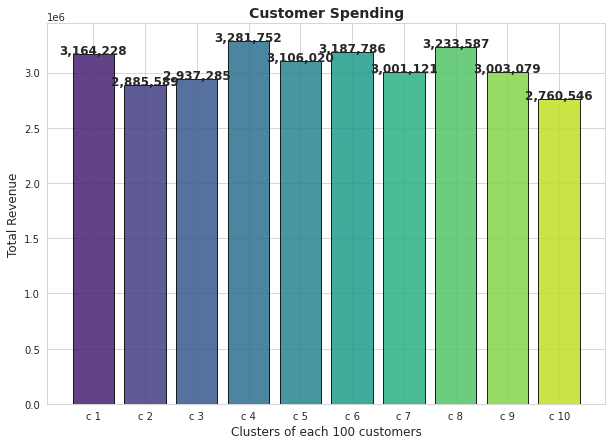

In [0]:
visualize(clusters['cluster_id'],clusters['Total revenue'],"Customer Spending","Clusters of each 100 customers","Total Revenue")

#### Visualizing total revenue of each category

In [0]:
products_list.display()

Product_name,category,total
Toaster,Home & Kitchen,7514255.409999999
Yoga Mat,Sports,6235214.489999999
RC Car,Toys,5008281.600000001
Smartphone,Electronics,4480974.46
Jeans,Clothing,4334505.729999999
Biography,Books,3036450.79


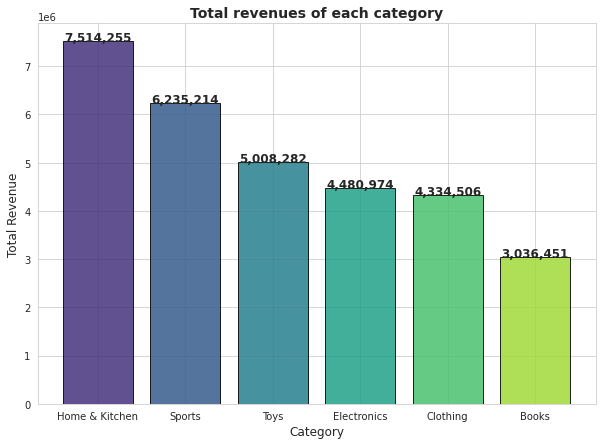

In [0]:
data=products_list.toPandas()
visualize(data['category'],data['total'],"Total revenues of each category","Category","Total Revenue")

### visualizing shipping delays for top products

##### First grouped the product-id based upon the quantity of the highest sold items.
##### selected top10 most sold items and joined with prodcts_data to get the category of the products.
##### By using matplotlib.pyplt and seaborn created a bar plot and pie plot .

In [0]:
from pyspark.sql.functions import sum
products_quantity=orders_data.groupBy('product_id').agg(sum('quantity').alias('Total quantity')).orderBy(col('Total quantity').desc()).limit(10)
products_quantity.display()
final_shipment_delays=products_quantity.join(shipment_delays.select('product_id','date_differnces'),on='product_id',how='left')
final_shipment_delays=final_shipment_delays.groupBy('product_id').agg(avg('date_differnces'))\
    .join(products_data.select('product_id','product_name'),on='product_id',how='left')
final_shipment_delays=final_shipment_delays.groupBy('product_name').agg(avg('avg(date_differnces)').alias('average time delays')).order
final_shipment_delays.display()
# shipment_delays.display()

product_id,Total quantity
4,181
76,178
37,175
59,171
1,163
35,161
58,159
28,155
96,154
94,153


product_name,average time delays
Toaster,96.57363782051281
Yoga Mat,102.0063492063492
Biography,97.0958904109589
RC Car,81.56896551724138
Smartphone,95.14388952672535


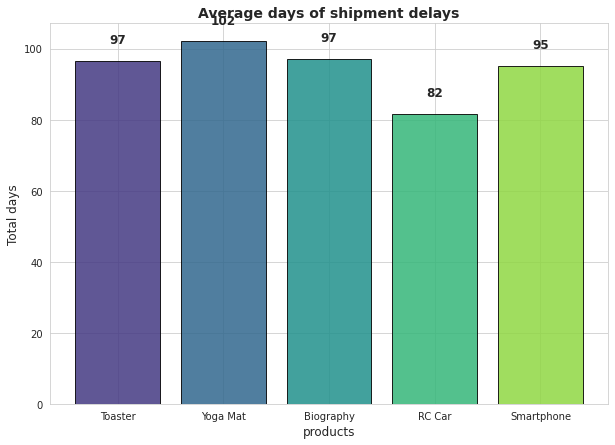

In [0]:
data=final_shipment_delays.toPandas()
visualize(data['product_name'],data['average time delays'],"Average days of shipment delays","products","Total days")

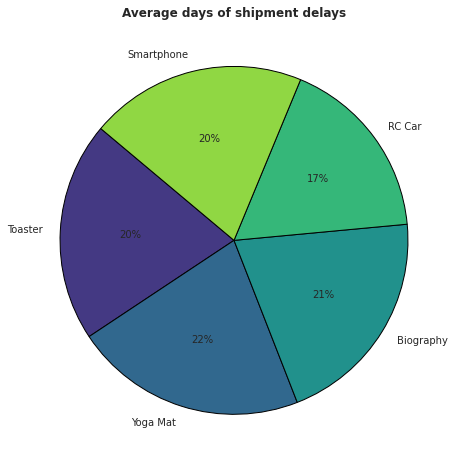

In [0]:
plt.figure(figsize=(8, 8))
labels=data['product_name']
values= data['average time delays']
plt.pie(
    values, labels=labels, 
    autopct='%.0f%%', startangle=140, 
    colors = sns.color_palette("viridis", len(labels)),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Average days of shipment delays", fontsize=12, fontweight="bold")
plt.show()